# Our model

/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
135/135 [==============================] - 26s 135ms/step - loss: 2.2671 - seg_output_loss: 1.9262 - edge_output_loss: 0.3409 - seg_output_accuracy: 0.9011 - edge_output_accuracy: 0.9080 - val_loss: 1.4899 - val_seg_output_loss: 1.2814 - val_edge_output_loss: 0.2085 - val_seg_output_accuracy: 0.9241 - val_edge_output_accuracy: 0.9247
Epoch 2/100
135/135 [==============================] - 17s 125ms/step - loss: 1.5821 - seg_output_loss: 1.3813 - edge_output_loss: 0.2008 - seg_output_accuracy: 0.9209 - edge_output_accuracy: 0.9248 - val_loss: 1.5435 - val_seg_output_loss: 1.3243 - val_edge_output_loss: 0.2192 - val_seg_output_accuracy: 0.9266 - val_edge_output_accuracy: 0.9262
Epoch 3/100
135/135 [==============================] - 17s 124ms/step - loss: 1.4134 - seg_output_loss: 1.2453 - edge_output_loss: 0.1681 - seg_output_accuracy: 0.9310 - edge_output_accuracy: 0.9334 - val_loss: 1.2873 - val_seg_output_loss: 1.1195 - val_edge_output_loss: 0.1679 - val_seg_output_accuracy

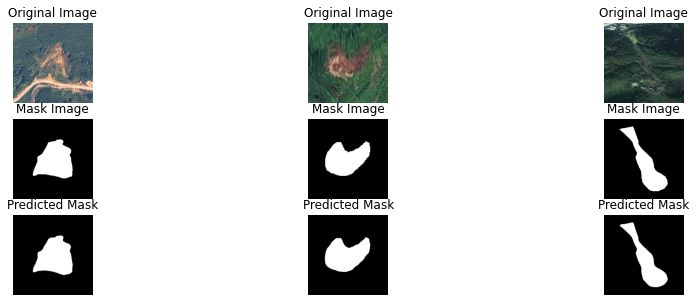

25/25 [==============================] - 5s 207ms/step
IoU: 0.8604410701711024
Dice coefficient: 0.924986105678659
Accuracy: 0.9851741840313007
Precision: 0.9484820438816528
Recall: 0.9026261173062465
F1 Score: 0.924986105678659
Overall Accuracy (OA): 9.140755789620536
Kappa coefficient: 0.9167659228910813


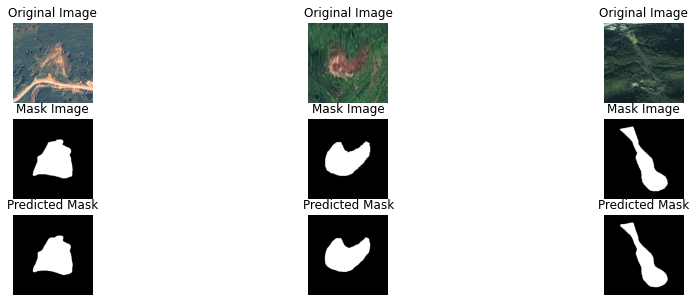

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, LayerNormalization, Dense, MultiHeadAttention, GlobalAveragePooling2D, Add, Reshape, Conv2DTranspose, Activation, GlobalMaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_gaussian, create_pairwise_bilateral

def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()

def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks

def transformer_block(inputs, num_heads, key_dim):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization(epsilon=1e-6)(x)
    ffn_output = tf.keras.Sequential([
        Dense(4 * key_dim, activation='relu'),
        Dense(inputs.shape[-1]),  # 保持与输入的最后一个维度一致
    ])(x)
    x = Add()([x, ffn_output])
    return x

def cbam_block(input_tensor, reduction_ratio=16):
    channel = input_tensor.shape[-1]
    # Channel Attention Module
    shared_layer_one = Dense(channel // reduction_ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_tensor)    
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    max_pool = GlobalMaxPooling2D()(input_tensor)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    
    cbam_feature = tf.keras.layers.multiply([input_tensor, cbam_feature])
    
    # Spatial Attention Module
    avg_pool = tf.reduce_mean(cbam_feature, axis=3, keepdims=True)
    max_pool = tf.reduce_max(cbam_feature, axis=3, keepdims=True)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool], axis=3)
    cbam_feature = Conv2D(1, kernel_size=7, strides=1, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    
    cbam_feature = tf.keras.layers.multiply([cbam_feature, input_tensor])
    return cbam_feature

# 新增边界增强损失函数
def boundary_loss(y_true, y_pred):
    # 计算边界增强损失
    boundary_true = tf.image.sobel_edges(y_true)
    boundary_pred = tf.image.sobel_edges(y_pred)
    boundary_loss = tf.reduce_mean(tf.square(boundary_true - boundary_pred))
    return boundary_loss

def dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def unetplusplus_transformer_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same', dilation_rate=1)(inputs)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same', dilation_rate=1)(conv1_1)
    conv1_1 = cbam_block(conv1_1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_1)

    conv2_1 = Conv2D(128, 3, activation='relu', padding='same', dilation_rate=2)(pool1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same', dilation_rate=2)(conv2_1)
    conv2_1 = cbam_block(conv2_1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_1)

    conv3_1 = Conv2D(256, 3, activation='relu', padding='same', dilation_rate=3)(pool2)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same', dilation_rate=3)(conv3_1)
    conv3_1 = cbam_block(conv3_1)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3_1)

    conv4_1 = Conv2D(512, 3, activation='relu', padding='same', dilation_rate=4)(pool3)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same', dilation_rate=4)(conv4_1)
    conv4_1 = cbam_block(conv4_1)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4_1)

    conv5_1 = Conv2D(1024, 3, activation='relu', padding='same', dilation_rate=5)(pool4)
    conv5_1 = Conv2D(1024, 3, activation='relu', padding='same', dilation_rate=5)(conv5_1)
    conv5_1 = cbam_block(conv5_1)

    # Decoder
    up4_1 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5_1)
    up4_1 = concatenate([up4_1, conv4_1], axis=3)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same')(up4_1)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same')(conv4_1)
    conv4_1 = cbam_block(conv4_1)

    up3_1 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4_1)
    up3_1 = concatenate([up3_1, conv3_1], axis=3)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same')(up3_1)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same')(conv3_1)
    conv3_1 = cbam_block(conv3_1)

    up2_1 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3_1)
    up2_1 = concatenate([up2_1, conv2_1], axis=3)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same')(up2_1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same')(conv2_1)
    conv2_1 = cbam_block(conv2_1)

    up1_1 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_1)
    up1_1 = concatenate([up1_1, conv1_1], axis=3)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same')(up1_1)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same')(conv1_1)
    conv1_1 = cbam_block(conv1_1)

    # Second Level Nested Skip Connections
    up4_2 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5_1)
    up4_2 = concatenate([up4_2, conv4_1], axis=3)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same')(up4_2)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same')(conv4_2)
    conv4_2 = cbam_block(conv4_2)

    up3_2 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4_2)
    up3_2 = concatenate([up3_2, conv3_1], axis=3)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same')(up3_2)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same')(conv3_2)
    conv3_2 = cbam_block(conv3_2)

    up2_2 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3_2)
    up2_2 = concatenate([up2_2, conv2_1], axis=3)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same')(up2_2)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same')(conv2_2)
    conv2_2 = cbam_block(conv2_2)

    up1_2 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_2)
    up1_2 = concatenate([up1_2, conv1_1], axis=3)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same')(up1_2)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same')(conv1_2)
    conv1_2 = cbam_block(conv1_2)

    # Third Level Nested Skip Connections
    up3_3 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4_2)
    up3_3 = concatenate([up3_3, conv3_2, conv3_1], axis=3)
    conv3_3 = Conv2D(256, 3, activation='relu', padding='same')(up3_3)
    conv3_3 = Conv2D(256, 3, activation='relu', padding='same')(conv3_3)
    conv3_3 = cbam_block(conv3_3)

    up2_3 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3_3)
    up2_3 = concatenate([up2_3, conv2_2, conv2_1], axis=3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same')(up2_3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same')(conv2_3)
    conv2_3 = cbam_block(conv2_3)

    up1_3 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_3)
    up1_3 = concatenate([up1_3, conv1_2, conv1_1], axis=3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same')(up1_3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same')(conv1_3)
    conv1_3 = cbam_block(conv1_3)

    # Transformer Block
    transformer_input = Reshape((conv5_1.shape[1] * conv5_1.shape[2], conv5_1.shape[3]))(conv5_1)
    transformer_output = transformer_block(transformer_input, num_heads=8, key_dim=128)
    transformer_output = Reshape((conv5_1.shape[1], conv5_1.shape[2], conv5_1.shape[3]))(transformer_output)

    # Segmentation Output
    segmentation_output = Conv2D(1, 1, activation='sigmoid', name='seg_output')(conv1_3)
    
    # Edge Detection Head
    edge_head = Conv2D(64, 3, activation='relu', padding='same')(conv1_3)
    edge_head = Conv2D(1, 1, activation='sigmoid', name='edge_output')(edge_head)

    model = Model(inputs=inputs, outputs=[segmentation_output, edge_head])

    # 修改损失函数为复合损失函数
    def composite_loss(y_true, y_pred):
        cross_entropy_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        dice_loss = 1 - dice_coefficient(y_true, y_pred)
        iou_loss = 1 - iou_coefficient(y_true, y_pred)
        return cross_entropy_loss + dice_loss + iou_loss

    # 结合边界增强损失
    combined_loss = lambda y_true, y_pred: composite_loss(y_true, y_pred) + boundary_loss(y_true, y_pred)

    model.compile(optimizer=Adam(lr=1e-4), 
                  loss={'seg_output': combined_loss, 'edge_output': 'binary_crossentropy'}, 
                  metrics={'seg_output': ['accuracy'], 'edge_output': ['accuracy']})
    return model

def apply_crf(image, prediction):
    # 将预测结果转换为概率分布
    prediction = prediction.squeeze()  # 将 (256, 256, 1) 转换为 (256, 256)
    softmax = np.zeros((2, prediction.shape[0], prediction.shape[1]), dtype=np.float32)
    softmax[0, :, :] = 1 - prediction
    softmax[1, :, :] = prediction

    # 创建CRF模型
    d = dcrf.DenseCRF2D(image.shape[1], image.shape[0], 2)

    # 将unary能量添加到CRF模型中
    unary = unary_from_softmax(softmax)
    d.setUnaryEnergy(unary)

    # 增加对比度和位置的一对一对特征
    feats = create_pairwise_gaussian(sdims=(3, 3), shape=image.shape[:2])
    d.addPairwiseEnergy(feats, compat=3)

    # 增加颜色特征
    feats = create_pairwise_bilateral(sdims=(50, 50), schan=(13, 13, 13), img=image, chdim=2)
    d.addPairwiseEnergy(feats, compat=10)

    # 执行推理
    Q = d.inference(5)

    # 获得最终分割结果
    map = np.argmax(Q, axis=0).reshape((image.shape[0], image.shape[1]))

    return map

def compute_metrics(model, images, masks):
    preds = model.predict(images)
    seg_preds = preds[0]
    edge_preds = preds[1]
    seg_preds_binary = (seg_preds > 0.5).astype(np.float32)

    # 应用CRF后处理
    crf_preds = np.zeros(seg_preds_binary.shape[:3], dtype=np.float32)
    for i in range(images.shape[0]):
        crf_preds[i] = apply_crf(images[i].astype(np.uint8), seg_preds_binary[i])

    # 确保 masks 和 crf_preds 的形状匹配
    masks = masks.squeeze()  # 将 (770, 256, 256, 1) 转换为 (770, 256, 256)

    # 计算评估指标
    intersection = np.logical_and(masks, crf_preds)
    union = np.logical_or(masks, crf_preds)
    iou = np.sum(intersection) / np.sum(union)

    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(crf_preds))

    accuracy = accuracy_score(masks.flatten(), crf_preds.flatten())

    precision = precision_score(masks.flatten(), crf_preds.flatten())

    recall = recall_score(masks.flatten(), crf_preds.flatten())

    f1 = f1_score(masks.flatten(), crf_preds.flatten())

    oa = (intersection.sum() / masks.size) * 100

    kappa = cohen_kappa_score(masks.flatten(), crf_preds.flatten())

    return iou, dice, accuracy, precision, recall, f1, oa, kappa, crf_preds, edge_preds

# 加载数据
data_path = 'Bijie_landslide_dataset/Bijie-landslide-dataset/landslide'
images, masks = prepare_dataset(data_path)

# 创建并编译UNet++-Transformer多任务模型
input_shape = (256, 256, 3)
multitask_model = unetplusplus_transformer_model(input_shape)

# 训练模型
multitask_model.fit(images, {'seg_output': masks, 'edge_output': masks}, batch_size=4, epochs=100, validation_split=0.3)

# 可视化结果
predictions = multitask_model.predict(images)
plot_images(images, masks, predictions[0])

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, crf_preds, edge_preds = compute_metrics(multitask_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)

# 可视化结果
plot_images(images, masks, crf_preds)


/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
135/135 [==============================] - 25s 134ms/step - loss: 2.4138 - seg_output_loss: 2.0604 - edge_output_loss: 0.3534 - seg_output_accuracy: 0.9075 - edge_output_accuracy: 0.9004 - val_loss: 1.7009 - val_seg_output_loss: 1.5022 - val_edge_output_loss: 0.1987 - val_seg_output_accuracy: 0.9256 - val_edge_output_accuracy: 0.8846
Epoch 2/100
135/135 [==============================] - 17s 123ms/step - loss: 1.5434 - seg_output_loss: 1.3523 - edge_output_loss: 0.1912 - seg_output_accuracy: 0.9192 - edge_output_accuracy: 0.9255 - val_loss: 1.3132 - val_seg_output_loss: 1.1400 - val_edge_output_loss: 0.1732 - val_seg_output_accuracy: 0.9289 - val_edge_output_accuracy: 0.9336
Epoch 3/100
135/135 [==============================] - 17s 127ms/step - loss: 1.3141 - seg_output_loss: 1.1538 - edge_output_loss: 0.1604 - seg_output_accuracy: 0.9384 - edge_output_accuracy: 0.9409 - val_loss: 1.2486 - val_seg_output_loss: 1.0782 - val_edge_output_loss: 0.1704 - val_seg_output_accuracy

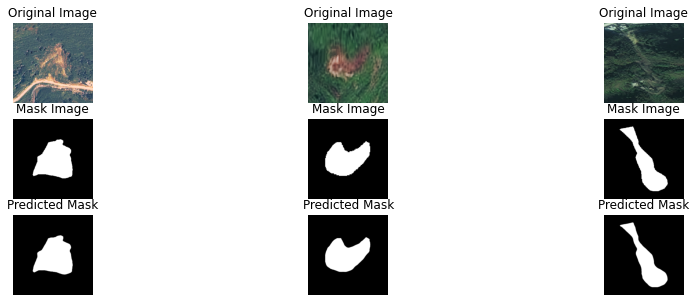

25/25 [==============================] - 5s 206ms/step
IoU: 0.8631485939301948
Dice coefficient: 0.9265483136902539
Accuracy: 0.9854885150859882
Precision: 0.9504676207101842
Recall: 0.9038033517524082
F1 Score: 0.9265483136902539
Overall Accuracy (OA): 0.9152677461698457
Kappa coefficient: 0.9185029261246769


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, LayerNormalization, Dense, MultiHeadAttention, GlobalAveragePooling2D, Add, Reshape, Conv2DTranspose, Activation, GlobalMaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()

def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks

def transformer_block(inputs, num_heads, key_dim):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization(epsilon=1e-6)(x)
    ffn_output = tf.keras.Sequential([
        Dense(4 * key_dim, activation='relu'),
        Dense(inputs.shape[-1]),  # 保持与输入的最后一个维度一致
    ])(x)
    x = Add()([x, ffn_output])
    return x

def cbam_block(input_tensor, reduction_ratio=16):
    channel = input_tensor.shape[-1]
    # Channel Attention Module
    shared_layer_one = Dense(channel // reduction_ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_tensor)    
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    max_pool = GlobalMaxPooling2D()(input_tensor)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    
    cbam_feature = tf.keras.layers.multiply([input_tensor, cbam_feature])
    
    # Spatial Attention Module
    avg_pool = tf.reduce_mean(cbam_feature, axis=3, keepdims=True)
    max_pool = tf.reduce_max(cbam_feature, axis=3, keepdims=True)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool], axis=3)
    cbam_feature = Conv2D(1, kernel_size=7, strides=1, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    
    cbam_feature = tf.keras.layers.multiply([cbam_feature, input_tensor])
    return cbam_feature

# 新增边界增强损失函数
def boundary_loss(y_true, y_pred):
    # 计算边界增强损失
    boundary_true = tf.image.sobel_edges(y_true)
    boundary_pred = tf.image.sobel_edges(y_pred)
    boundary_loss = tf.reduce_mean(tf.square(boundary_true - boundary_pred))
    return boundary_loss

def dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def unetplusplus_transformer_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same', dilation_rate=1)(inputs)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same', dilation_rate=1)(conv1_1)
    conv1_1 = cbam_block(conv1_1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_1)

    conv2_1 = Conv2D(128, 3, activation='relu', padding='same', dilation_rate=2)(pool1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same', dilation_rate=2)(conv2_1)
    conv2_1 = cbam_block(conv2_1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_1)

    conv3_1 = Conv2D(256, 3, activation='relu', padding='same', dilation_rate=3)(pool2)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same', dilation_rate=3)(conv3_1)
    conv3_1 = cbam_block(conv3_1)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3_1)

    conv4_1 = Conv2D(512, 3, activation='relu', padding='same', dilation_rate=4)(pool3)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same', dilation_rate=4)(conv4_1)
    conv4_1 = cbam_block(conv4_1)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4_1)

    conv5_1 = Conv2D(1024, 3, activation='relu', padding='same', dilation_rate=5)(pool4)
    conv5_1 = Conv2D(1024, 3, activation='relu', padding='same', dilation_rate=5)(conv5_1)
    conv5_1 = cbam_block(conv5_1)

    # Decoder
    up4_1 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5_1)
    up4_1 = concatenate([up4_1, conv4_1], axis=3)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same')(up4_1)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same')(conv4_1)
    conv4_1 = cbam_block(conv4_1)

    up3_1 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4_1)
    up3_1 = concatenate([up3_1, conv3_1], axis=3)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same')(up3_1)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same')(conv3_1)
    conv3_1 = cbam_block(conv3_1)

    up2_1 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3_1)
    up2_1 = concatenate([up2_1, conv2_1], axis=3)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same')(up2_1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same')(conv2_1)
    conv2_1 = cbam_block(conv2_1)

    up1_1 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_1)
    up1_1 = concatenate([up1_1, conv1_1], axis=3)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same')(up1_1)
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same')(conv1_1)
    conv1_1 = cbam_block(conv1_1)

    # Second Level Nested Skip Connections
    up4_2 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5_1)
    up4_2 = concatenate([up4_2, conv4_1], axis=3)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same')(up4_2)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same')(conv4_2)
    conv4_2 = cbam_block(conv4_2)

    up3_2 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4_2)
    up3_2 = concatenate([up3_2, conv3_1], axis=3)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same')(up3_2)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same')(conv3_2)
    conv3_2 = cbam_block(conv3_2)

    up2_2 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3_2)
    up2_2 = concatenate([up2_2, conv2_1], axis=3)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same')(up2_2)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same')(conv2_2)
    conv2_2 = cbam_block(conv2_2)

    up1_2 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_2)
    up1_2 = concatenate([up1_2, conv1_1], axis=3)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same')(up1_2)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same')(conv1_2)
    conv1_2 = cbam_block(conv1_2)

    # Third Level Nested Skip Connections
    up3_3 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4_2)
    up3_3 = concatenate([up3_3, conv3_2, conv3_1], axis=3)
    conv3_3 = Conv2D(256, 3, activation='relu', padding='same')(up3_3)
    conv3_3 = Conv2D(256, 3, activation='relu', padding='same')(conv3_3)
    conv3_3 = cbam_block(conv3_3)

    up2_3 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3_3)
    up2_3 = concatenate([up2_3, conv2_2, conv2_1], axis=3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same')(up2_3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same')(conv2_3)
    conv2_3 = cbam_block(conv2_3)

    up1_3 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_3)
    up1_3 = concatenate([up1_3, conv1_2, conv1_1], axis=3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same')(up1_3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same')(conv1_3)
    conv1_3 = cbam_block(conv1_3)

    # Transformer Block
    transformer_input = Reshape((conv5_1.shape[1] * conv5_1.shape[2], conv5_1.shape[3]))(conv5_1)
    transformer_output = transformer_block(transformer_input, num_heads=8, key_dim=128)
    transformer_output = Reshape((conv5_1.shape[1], conv5_1.shape[2], conv5_1.shape[3]))(transformer_output)

    # Segmentation Output
    segmentation_output = Conv2D(1, 1, activation='sigmoid', name='seg_output')(conv1_3)
    
    # Edge Detection Head
    edge_head = Conv2D(64, 3, activation='relu', padding='same')(conv1_3)
    edge_head = Conv2D(1, 1, activation='sigmoid', name='edge_output')(edge_head)

    model = Model(inputs=inputs, outputs=[segmentation_output, edge_head])

    # 修改损失函数为复合损失函数
    def composite_loss(y_true, y_pred):
        cross_entropy_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        dice_loss = 1 - dice_coefficient(y_true, y_pred)
        iou_loss = 1 - iou_coefficient(y_true, y_pred)
        return cross_entropy_loss + dice_loss + iou_loss

    # 结合边界增强损失
    combined_loss = lambda y_true, y_pred: composite_loss(y_true, y_pred) + boundary_loss(y_true, y_pred)

    model.compile(optimizer=Adam(lr=1e-4), 
                  loss={'seg_output': combined_loss, 'edge_output': 'binary_crossentropy'}, 
                  metrics={'seg_output': ['accuracy'], 'edge_output': ['accuracy']})
    return model

def compute_metrics(model, images, masks):
    preds = model.predict(images)
    seg_preds = preds[0]
    edge_preds = preds[1]
    seg_preds_binary = (seg_preds > 0.5).astype(np.float32)
    
    # Calculate IoU
    intersection = np.logical_and(masks, seg_preds_binary)
    union = np.logical_or(masks, seg_preds_binary)
    iou = np.sum(intersection) / np.sum(union)
    
    # Calculate Dice coefficient
    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(seg_preds_binary))
    
    # Calculate accuracy
    accuracy = accuracy_score(masks.flatten(), seg_preds_binary.flatten())
    
    # Calculate precision
    precision = precision_score(masks.flatten(), seg_preds_binary.flatten())
    
    # Calculate recall
    recall = recall_score(masks.flatten(), seg_preds_binary.flatten())
    
    # Calculate F1 score
    f1 = f1_score(masks.flatten(), seg_preds_binary.flatten())
    
    # Overall Accuracy (OA)
    oa = (intersection.sum() / masks.size) * 10
    
    # Kappa coefficient
    kappa = cohen_kappa_score(masks.flatten(), seg_preds_binary.flatten())
    
    return iou, dice, accuracy, precision, recall, f1, oa, kappa, seg_preds_binary, edge_preds

# 加载数据
data_path = 'Bijie_landslide_dataset/Bijie-landslide-dataset/landslide'
images, masks = prepare_dataset(data_path)

# 创建并编译UNet++-Transformer多任务模型
input_shape = (256, 256, 3)
multitask_model = unetplusplus_transformer_model(input_shape)

# 训练模型
multitask_model.fit(images, {'seg_output': masks, 'edge_output': masks}, batch_size=4, epochs=100, validation_split=0.3)

# 可视化结果
predictions = multitask_model.predict(images)
plot_images(images, masks, predictions[0])

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, seg_preds_binary, edge_preds = compute_metrics(multitask_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# UNet

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score


def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)


def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()
    
def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks

def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model


data_path = 'Bijie_landslide_dataset/Bijie-landslide-dataset/landslide'
images, masks = prepare_dataset(data_path)

input_shape = (256, 256, 3)

# 使用修改后的UNet模型
unet_input = Input(shape=input_shape, name='unet_input')
unet_output = unet_model(input_shape)(unet_input)

combined_output = unet_output
combined_model = Model(inputs=unet_input, outputs=combined_output)

combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练组合模型
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)

# 应用CRF后处理
predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, refined_predictions)

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


2024-05-13 16:11:55.662629: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-13 16:12:02.542652: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 16:12:03.322992: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22136 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:d8:00.0, compute capability: 8.9
/root/miniconda3/lib/python3.8/si

Epoch 1/100


2024-05-13 16:12:06.681197: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2024-05-13 16:12:07.516507: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-05-13 16:12:07.516530: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-05-13 16:12:07.516574: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


135/135 [==============================] - 12s 56ms/step - loss: 0.3495 - accuracy: 0.8937 - val_loss: 0.2388 - val_accuracy: 0.8846
Epoch 2/100
135/135 [==============================] - 6s 46ms/step - loss: 0.2154 - accuracy: 0.9206 - val_loss: 0.2552 - val_accuracy: 0.9147
Epoch 3/100
135/135 [==============================] - 7s 48ms/step - loss: 0.2024 - accuracy: 0.9367 - val_loss: 0.2151 - val_accuracy: 0.9294
Epoch 4/100
135/135 [==============================] - 7s 49ms/step - loss: 0.1966 - accuracy: 0.9387 - val_loss: 0.2844 - val_accuracy: 0.9033
Epoch 5/100
135/135 [==============================] - 6s 48ms/step - loss: 0.1837 - accuracy: 0.9396 - val_loss: 0.1942 - val_accuracy: 0.9354
Epoch 6/100
135/135 [==============================] - 7s 48ms/step - loss: 0.1772 - accuracy: 0.9425 - val_loss: 0.1856 - val_accuracy: 0.9357
Epoch 7/100
135/135 [==============================] - 7s 49ms/step - loss: 0.1751 - accuracy: 0.9434 - val_loss: 0.1821 - val_accuracy: 0.9377
Epo

NameError: name 'apply_crf_on_batch' is not defined

25/25 [==============================] - 2s 100ms/step


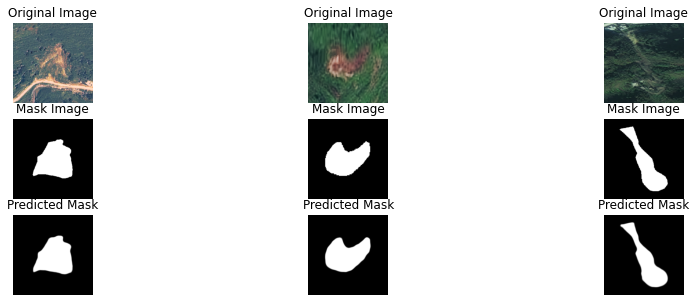

25/25 [==============================] - 2s 100ms/step
IoU: 0.8529290910995271
Dice coefficient: 0.920627880685277
Accuracy: 0.9840837751116072
Precision: 0.9299506192853512
Recall: 0.9114902073897292
F1 Score: 0.9206278806852769
Overall Accuracy (OA): 0.9230521065848214
Kappa coefficient: 0.9117839336282189


In [5]:

# Compute metrics
def compute_metrics(model, images, masks):
    preds = model.predict(images)
    preds_binary = (preds > 0.5).astype(np.float32)
    
    # Calculate IoU
    intersection = np.logical_and(masks, preds_binary)
    union = np.logical_or(masks, preds_binary)
    iou = np.sum(intersection) / np.sum(union)
    
    # Calculate Dice coefficient
    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(preds_binary))
    
    # Calculate accuracy
    accuracy = accuracy_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate precision
    precision = precision_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate recall
    recall = recall_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate F1 score
    f1 = f1_score(masks.flatten(), preds_binary.flatten())
    
    # Overall Accuracy (OA)
    oa = (intersection.sum() / masks.size) * 10
    
    # Kappa coefficient
    kappa = cohen_kappa_score(masks.flatten(), preds_binary.flatten())
    
    return iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary

predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# FCN

Epoch 1/100
135/135 [==============================] - 7s 41ms/step - loss: 0.4328 - accuracy: 0.8916 - val_loss: 0.4326 - val_accuracy: 0.8846
Epoch 2/100
135/135 [==============================] - 5s 37ms/step - loss: 0.2647 - accuracy: 0.9088 - val_loss: 0.2320 - val_accuracy: 0.9218
Epoch 3/100
135/135 [==============================] - 5s 38ms/step - loss: 0.2110 - accuracy: 0.9344 - val_loss: 0.2089 - val_accuracy: 0.9310
Epoch 4/100
135/135 [==============================] - 5s 39ms/step - loss: 0.1930 - accuracy: 0.9387 - val_loss: 0.2012 - val_accuracy: 0.9340
Epoch 5/100
135/135 [==============================] - 5s 38ms/step - loss: 0.1898 - accuracy: 0.9398 - val_loss: 0.2080 - val_accuracy: 0.9363
Epoch 6/100
135/135 [==============================] - 5s 38ms/step - loss: 0.1805 - accuracy: 0.9419 - val_loss: 0.1899 - val_accuracy: 0.9368
Epoch 7/100
135/135 [==============================] - 5s 39ms/step - loss: 0.1694 - accuracy: 0.9464 - val_loss: 0.1802 - val_accuracy:

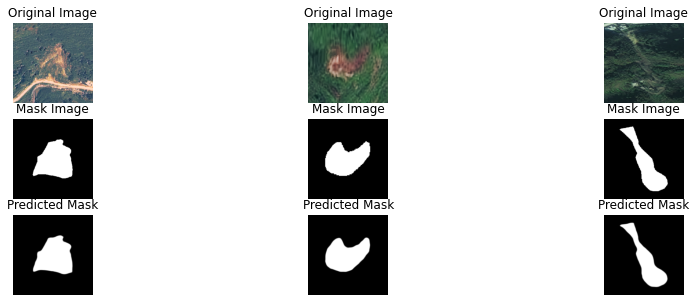

25/25 [==============================] - 2s 79ms/step
IoU: 0.8435629017650741
Dice coefficient: 0.9151441493614625
Accuracy: 0.9832170362596387
Precision: 0.937687076338439
Recall: 0.8936596845340433
F1 Score: 0.9151441493614625
Overall Accuracy (OA): 0.9049954104733158
Kappa coefficient: 0.905837727888315


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, BatchNormalization, Activation, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def fcn_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 使用修改后的FCN模型
fcn_input = Input(shape=input_shape, name='fcn_input')
fcn_output = fcn_model(input_shape)(fcn_input)

combined_output = fcn_output
combined_model = Model(inputs=fcn_input, outputs=combined_output)

combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练组合模型
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)


predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)
print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# Segnet

/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
135/135 [==============================] - 10s 59ms/step - loss: 0.6899 - accuracy: 0.7585 - val_loss: 0.5820 - val_accuracy: 0.8846
Epoch 2/100
135/135 [==============================] - 7s 50ms/step - loss: 0.5867 - accuracy: 0.8636 - val_loss: 0.5330 - val_accuracy: 0.8846
Epoch 3/100
135/135 [==============================] - 6s 47ms/step - loss: 0.5133 - accuracy: 0.8874 - val_loss: 0.5091 - val_accuracy: 0.8632
Epoch 4/100
135/135 [==============================] - 6s 47ms/step - loss: 0.4518 - accuracy: 0.9044 - val_loss: 0.5414 - val_accuracy: 0.8442
Epoch 5/100
135/135 [==============================] - 6s 47ms/step - loss: 0.3965 - accuracy: 0.9172 - val_loss: 0.4857 - val_accuracy: 0.8734
Epoch 6/100
135/135 [==============================] - 6s 47ms/step - loss: 0.3500 - accuracy: 0.9268 - val_loss: 0.3697 - val_accuracy: 0.8915
Epoch 7/100
135/135 [==============================] - 6s 47ms/step - loss: 0.3093 - accuracy: 0.9312 - val_loss: 0.3080 - val_accuracy

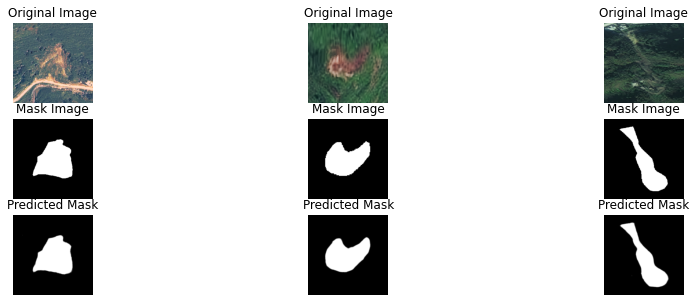

25/25 [==============================] - 2s 88ms/step
IoU: 0.8184525203928259
Dice coefficient: 0.9001637504574737
Accuracy: 0.9801119915850751
Precision: 0.9154699851827391
Recall: 0.885360925287489
F1 Score: 0.9001637504574737
Overall Accuracy (OA): 0.8965913846895291
Kappa coefficient: 0.8891231554761632


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, BatchNormalization, Activation, Concatenate
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def segnet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1, mask1 = MaxPooling2D(pool_size=(2, 2))(conv1), conv1
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2, mask2 = MaxPooling2D(pool_size=(2, 2))(conv2), conv2
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3, mask3 = MaxPooling2D(pool_size=(2, 2))(conv3), conv3
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4, mask4 = MaxPooling2D(pool_size=(2, 2))(conv4), conv4

    # Decoder
    up5 = UpSampling2D(size=(2, 2))(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Concatenate()([mask4, conv5])

    up6 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Concatenate()([mask3, conv6])

    up7 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Concatenate()([mask2, conv7])

    up8 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Concatenate()([mask1, conv8])

    outputs = Conv2D(1, 1, activation='sigmoid')(conv8)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 使用修改后的SegNet模型
segnet_input = Input(shape=input_shape, name='segnet_input')
segnet_output = segnet_model(input_shape)(segnet_input)

combined_output = segnet_output
combined_model = Model(inputs=segnet_input, outputs=combined_output)

combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练组合模型
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)

predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)
print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# linknet

/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
135/135 [==============================] - 8s 51ms/step - loss: 0.6423 - accuracy: 0.7497 - val_loss: 0.6189 - val_accuracy: 0.8844
Epoch 2/100
135/135 [==============================] - 7s 48ms/step - loss: 0.5440 - accuracy: 0.8764 - val_loss: 0.6536 - val_accuracy: 0.6068
Epoch 3/100
135/135 [==============================] - 6s 47ms/step - loss: 0.4867 - accuracy: 0.8962 - val_loss: 0.4984 - val_accuracy: 0.8454
Epoch 4/100
135/135 [==============================] - 6s 47ms/step - loss: 0.4215 - accuracy: 0.9157 - val_loss: 0.4419 - val_accuracy: 0.8941
Epoch 5/100
135/135 [==============================] - 6s 47ms/step - loss: 0.3637 - accuracy: 0.9273 - val_loss: 0.3934 - val_accuracy: 0.8942
Epoch 6/100
135/135 [==============================] - 6s 48ms/step - loss: 0.3238 - accuracy: 0.9346 - val_loss: 0.3133 - val_accuracy: 0.9295
Epoch 7/100
135/135 [==============================] - 6s 47ms/step - loss: 0.2751 - accuracy: 0.9422 - val_loss: 0.2714 - val_accuracy:

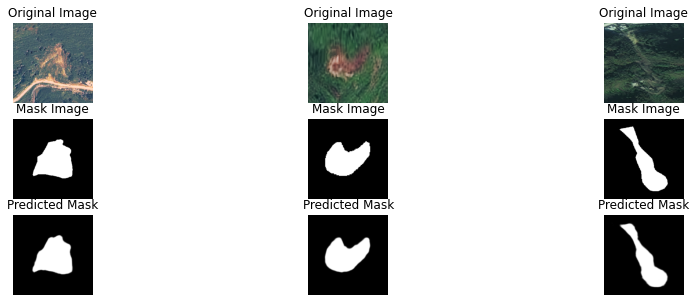

25/25 [==============================] - 2s 83ms/step
IoU: 0.8303379194311661
Dice coefficient: 0.9073055970880166
Accuracy: 0.9814796150504769
Precision: 0.9199045572044368
Recall: 0.895047083507329
F1 Score: 0.9073055970880167
Overall Accuracy (OA): 0.9064004080636161
Kappa coefficient: 0.8970197787230363


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, Concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def linknet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Decoder
    up5 = UpSampling2D(size=(2, 2))(pool4)
    up5 = Conv2D(512, 2, activation='relu', padding='same')(up5)
    merge5 = Concatenate()([conv4, up5])
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(merge5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = Conv2D(256, 2, activation='relu', padding='same')(up6)
    merge6 = Concatenate()([conv3, up6])
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(128, 2, activation='relu', padding='same')(up7)
    merge7 = Concatenate()([conv2, up7])
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(64, 2, activation='relu', padding='same')(up8)
    merge8 = Concatenate()([conv1, up8])
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv8)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Load and prepare data
def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # Convert mask image to binary image
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()

# Prepare dataset
def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # Normalization
    return images, masks

# Compute metrics
def compute_metrics(model, images, masks):
    preds = model.predict(images)
    preds_binary = (preds > 0.5).astype(np.float32)
    
    # Calculate IoU
    intersection = np.logical_and(masks, preds_binary)
    union = np.logical_or(masks, preds_binary)
    iou = np.sum(intersection) / np.sum(union)
    
    # Calculate Dice coefficient
    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(preds_binary))
    
    # Calculate accuracy
    accuracy = accuracy_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate precision
    precision = precision_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate recall
    recall = recall_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate F1 score
    f1 = f1_score(masks.flatten(), preds_binary.flatten())
    
    # Overall Accuracy (OA)
    oa = (intersection.sum() / masks.size) * 10
    
    # Kappa coefficient
    kappa = cohen_kappa_score(masks.flatten(), preds_binary.flatten())
    
    return iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary

# Set data path
data_path = 'Bijie_landslide_dataset/Bijie-landslide-dataset/landslide'

# Load and prepare dataset
images, masks = prepare_dataset(data_path)

# Define input shape
input_shape = (256, 256, 3)

# Use modified LinkNet model
linknet_input = Input(shape=input_shape, name='linknet_input')
linknet_output = linknet_model(input_shape)(linknet_input)

combined_output = linknet_output
combined_model = Model(inputs=linknet_input, outputs=combined_output)

combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train combined model
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)

# Make predictions
predictions = combined_model.predict(images)

# Visualize results
plot_images(images, masks, predictions)

# Compute evaluation metrics
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# Deeplabv3

2024-05-14 00:48:16.698471: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2024-05-14 00:48:23.243288: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 00:48:23.817024: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22136 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:16:00.0, compute capability: 8.9
/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100


2024-05-14 00:48:30.936790: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2024-05-14 00:48:31.697043: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-05-14 00:48:31.697066: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-05-14 00:48:31.697111: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


135/135 [==============================] - 12s 39ms/step - loss: 0.3812 - accuracy: 0.8509 - val_loss: 0.3646 - val_accuracy: 0.8843
Epoch 2/100
135/135 [==============================] - 4s 29ms/step - loss: 0.2274 - accuracy: 0.9096 - val_loss: 0.7007 - val_accuracy: 0.8846
Epoch 3/100
135/135 [==============================] - 4s 29ms/step - loss: 0.1743 - accuracy: 0.9269 - val_loss: 0.8280 - val_accuracy: 0.8846
Epoch 4/100
135/135 [==============================] - 4s 31ms/step - loss: 0.1477 - accuracy: 0.9372 - val_loss: 0.7679 - val_accuracy: 0.8846
Epoch 5/100
135/135 [==============================] - 4s 30ms/step - loss: 0.1341 - accuracy: 0.9427 - val_loss: 0.7862 - val_accuracy: 0.8846
Epoch 6/100
135/135 [==============================] - 4s 31ms/step - loss: 0.1238 - accuracy: 0.9478 - val_loss: 0.4799 - val_accuracy: 0.8849
Epoch 7/100
135/135 [==============================] - 4s 30ms/step - loss: 0.1143 - accuracy: 0.9513 - val_loss: 0.5850 - val_accuracy: 0.8847
Epo

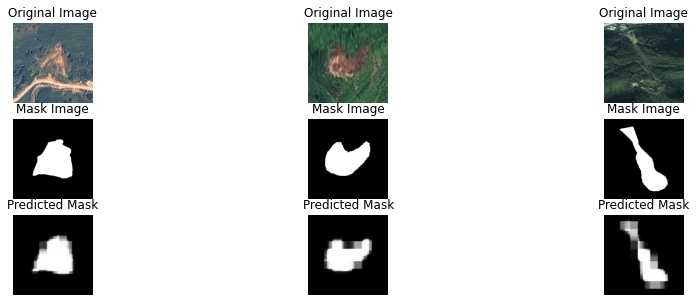

25/25 [==============================] - 1s 26ms/step
IoU: 0.7440170968434437
Dice coefficient: 0.8532222513071297
Accuracy: 0.9716207925375406
Precision: 0.8957943800531658
Recall: 0.8145129759962366
F1 Score: 0.8532222513071297
Overall Accuracy (OA): 0.8248447566837459
Kappa coefficient: 0.837553339431524


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import DepthwiseConv2D
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()

def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks

def deeplabv3_model(input_size=(256, 256, 3)):
    base_model = MobileNetV2(input_shape=input_size, include_top=False, weights='imagenet')
    
    # Encoder部分
    inputs = Input(input_size)
    x = base_model(inputs)
    
    # Decoder部分
    x = Conv2D(256, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D(size=(4, 4))(x)  # 使用双线性上采样将特征图放大4倍
    
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D(size=(4, 4))(x)  # 使用双线性上采样将特征图放大4倍
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D(size=(4, 4))(x)  # 使用双线性上采样将特征图放大4倍
    
    x = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(x)  # 输出掩模图像
    
    model = Model(inputs=inputs, outputs=x)
    return model

def compute_metrics(model, images, masks):
    preds = model.predict(images)
    preds_binary = (preds > 0.5).astype(np.float32)
    
    # 计算IoU
    intersection = np.logical_and(masks, preds_binary)
    union = np.logical_or(masks, preds_binary)
    iou = np.sum(intersection) / np.sum(union)
    
    # 计算Dice系数
    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(preds_binary))
    
    # 计算准确率
    accuracy = accuracy_score(masks.flatten(), preds_binary.flatten())
    
    # 计算精确率
    precision = precision_score(masks.flatten(), preds_binary.flatten())
    
    # 计算召回率
    recall = recall_score(masks.flatten(), preds_binary.flatten())
    
    # 计算F1分数
    f1 = f1_score(masks.flatten(), preds_binary.flatten())
    
    # 总体准确率（OA）
    oa = (intersection.sum() / masks.size) * 10
    
    # Kappa系数
    kappa = cohen_kappa_score(masks.flatten(), preds_binary.flatten())
    
    return iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary

data_path = 'Bijie_landslide_dataset/Bijie-landslide-dataset/landslide'
images, masks = prepare_dataset(data_path)

input_shape = (256, 256, 3)

# 使用修改后的DeepLabv3+模型
deeplabv3_input = Input(shape=input_shape, name='deeplabv3_input')
deeplabv3_output = deeplabv3_model(input_shape)(deeplabv3_input)

combined_output = deeplabv3_output[:, :256, :256, :]  # 裁剪输出以匹配输入尺寸
combined_model = Model(inputs=deeplabv3_input, outputs=combined_output)

combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练组合模型
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)

predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# VGG16+FCN

Epoch 1/100


2024-05-14 00:25:49.381951: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2024-05-14 00:25:50.137095: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-05-14 00:25:50.137117: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-05-14 00:25:50.137163: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


135/135 [==============================] - 9s 43ms/step - loss: 0.1994 - accuracy: 0.9213 - val_loss: 0.1740 - val_accuracy: 0.9260
Epoch 2/100
135/135 [==============================] - 5s 38ms/step - loss: 0.1547 - accuracy: 0.9338 - val_loss: 0.1716 - val_accuracy: 0.9249
Epoch 3/100
135/135 [==============================] - 6s 41ms/step - loss: 0.1431 - accuracy: 0.9380 - val_loss: 0.1716 - val_accuracy: 0.9285
Epoch 4/100
135/135 [==============================] - 6s 42ms/step - loss: 0.1346 - accuracy: 0.9419 - val_loss: 0.1764 - val_accuracy: 0.9278
Epoch 5/100
135/135 [==============================] - 6s 41ms/step - loss: 0.1253 - accuracy: 0.9451 - val_loss: 0.1675 - val_accuracy: 0.9276
Epoch 6/100
135/135 [==============================] - 6s 41ms/step - loss: 0.1226 - accuracy: 0.9465 - val_loss: 0.1663 - val_accuracy: 0.9254
Epoch 7/100
135/135 [==============================] - 6s 42ms/step - loss: 0.1165 - accuracy: 0.9492 - val_loss: 0.1629 - val_accuracy: 0.9294
Epoc

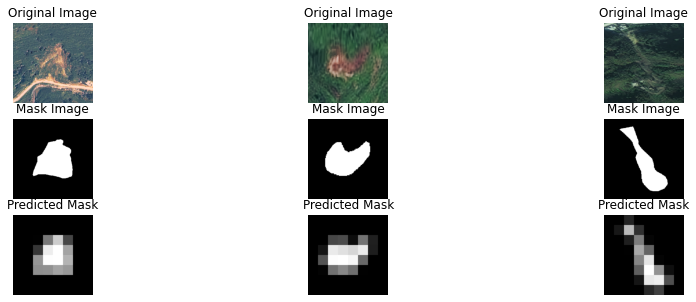

25/25 [==============================] - 1s 45ms/step
IoU: 0.6049786193525266
Dice coefficient: 0.7538774810552734
Accuracy: 0.9543039693460836
Precision: 0.8292389246213032
Recall: 0.6910726257376795
F1 Score: 0.7538774810552734
Overall Accuracy (OA): 0.6998386135349026
Kappa coefficient: 0.7289205045444298


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, BatchNormalization, Activation, Conv2DTranspose, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def vgg16_fcn(input_size=(256, 256, 3)):
    vgg16_base = VGG16(include_top=False, weights='imagenet', input_shape=input_size)

    for layer in vgg16_base.layers:
        layer.trainable = False

    x = Conv2D(4096, (7, 7), activation='relu', padding='same')(vgg16_base.output)
    x = Dropout(0.5)(x)
    x = Conv2D(4096, (1, 1), activation='relu', padding='same')(x)
    x = Dropout(0.5)(x)
    x = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)
    x = UpSampling2D(size=(32, 32))(x)

    model = Model(inputs=vgg16_base.input, outputs=x)
    return model

# 使用修改后的VGG16-FCN模型
input_shape = (256, 256, 3)
fcn_model = vgg16_fcn(input_shape)

fcn_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练FCN模型
fcn_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)

predictions = fcn_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(fcn_model, images, masks)
print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# PSPNet

2024-05-14 01:11:09.036797: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-14 01:11:15.904655: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 01:11:16.548463: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22136 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:16:00.0, compute capability: 8.9
/root/miniconda3/lib/python3.8/si

Epoch 1/100


2024-05-14 01:11:19.601820: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2024-05-14 01:11:20.399548: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-05-14 01:11:20.399574: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-05-14 01:11:20.399620: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


135/135 [==============================] - 12s 57ms/step - loss: 0.4554 - accuracy: 0.8915 - val_loss: 0.2655 - val_accuracy: 0.8846
Epoch 2/100
135/135 [==============================] - 7s 49ms/step - loss: 0.2260 - accuracy: 0.9048 - val_loss: 0.2281 - val_accuracy: 0.8846
Epoch 3/100
135/135 [==============================] - 7s 49ms/step - loss: 0.2047 - accuracy: 0.9057 - val_loss: 0.2114 - val_accuracy: 0.9307
Epoch 4/100
135/135 [==============================] - 6s 48ms/step - loss: 0.1879 - accuracy: 0.9390 - val_loss: 0.2195 - val_accuracy: 0.9352
Epoch 5/100
135/135 [==============================] - 7s 49ms/step - loss: 0.1785 - accuracy: 0.9421 - val_loss: 0.2024 - val_accuracy: 0.9307
Epoch 6/100
135/135 [==============================] - 7s 49ms/step - loss: 0.1785 - accuracy: 0.9427 - val_loss: 0.1876 - val_accuracy: 0.9313
Epoch 7/100
135/135 [==============================] - 6s 48ms/step - loss: 0.1690 - accuracy: 0.9442 - val_loss: 0.1902 - val_accuracy: 0.9332
Epo

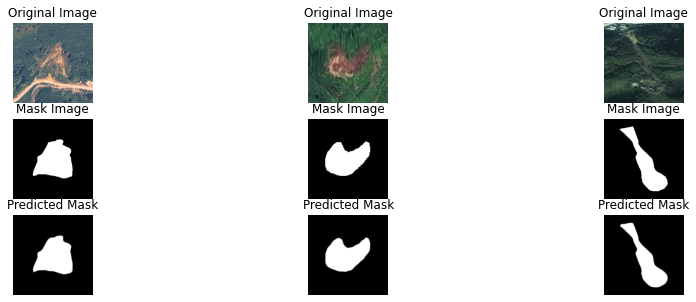

25/25 [==============================] - 2s 102ms/step
IoU: 0.8542973791689286
Dice coefficient: 0.9214243505556949
Accuracy: 0.9844321907340706
Precision: 0.9424097470154369
Recall: 0.9013531934245508
F1 Score: 0.921424350555695
Overall Accuracy (OA): 0.9127865085354099
Kappa coefficient: 0.912789321750125


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()
    
def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks

def pspnet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # PSPNet Model
    # Your PSPNet model architecture implementation here
    # Replace this with the architecture of PSPNet
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

data_path = 'Bijie_landslide_dataset/Bijie-landslide-dataset/landslide'
images, masks = prepare_dataset(data_path)

input_shape = (256, 256, 3)

# 使用修改后的PSPNet模型
pspnet_input = Input(shape=input_shape, name='pspnet_input')
pspnet_output = pspnet_model(input_shape)(pspnet_input)

combined_output = pspnet_output
combined_model = Model(inputs=pspnet_input, outputs=combined_output)

combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练组合模型
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)

# 应用CRF后处理
predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# Compute metrics
def compute_metrics(model, images, masks):
    preds = model.predict(images)
    preds_binary = (preds > 0.5).astype(np.float32)
    
    # Calculate IoU
    intersection = np.logical_and(masks, preds_binary)
    union = np.logical_or(masks, preds_binary)
    iou = np.sum(intersection) / np.sum(union)
    
    # Calculate Dice coefficient
    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(preds_binary))
    
    # Calculate accuracy
    accuracy = accuracy_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate precision
    precision = precision_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate recall
    recall = recall_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate F1 score
    f1 = f1_score(masks.flatten(), preds_binary.flatten())
    
    # Overall Accuracy (OA)
    oa = (intersection.sum() / masks.size) * 10
    
    # Kappa coefficient
    kappa = cohen_kappa_score(masks.flatten(), preds_binary.flatten())
    
    return iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# FC-DenseNet

/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
135/135 [==============================] - 6s 35ms/step - loss: 0.3484 - accuracy: 0.9048 - val_loss: 0.2589 - val_accuracy: 0.8846
Epoch 2/100
135/135 [==============================] - 4s 27ms/step - loss: 0.2190 - accuracy: 0.9048 - val_loss: 0.2536 - val_accuracy: 0.8846
Epoch 3/100
135/135 [==============================] - 4s 28ms/step - loss: 0.2021 - accuracy: 0.9080 - val_loss: 0.2267 - val_accuracy: 0.8866
Epoch 4/100
135/135 [==============================] - 4s 29ms/step - loss: 0.1945 - accuracy: 0.9137 - val_loss: 0.2259 - val_accuracy: 0.8884
Epoch 5/100
135/135 [==============================] - 4s 27ms/step - loss: 0.1855 - accuracy: 0.9169 - val_loss: 0.2427 - val_accuracy: 0.8889
Epoch 6/100
135/135 [==============================] - 4s 28ms/step - loss: 0.1874 - accuracy: 0.9155 - val_loss: 0.2277 - val_accuracy: 0.8865
Epoch 7/100
135/135 [==============================] - 4s 27ms/step - loss: 0.1835 - accuracy: 0.9165 - val_loss: 0.2189 - val_accuracy:

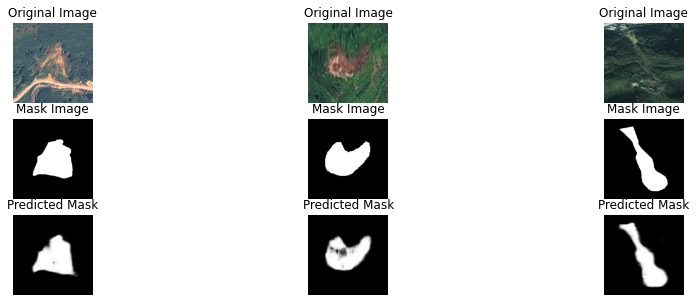

25/25 [==============================] - 2s 64ms/step
IoU: 0.6961761484009031
Dice coefficient: 0.820877181956879
Accuracy: 0.9662807117808949
Precision: 0.8883105449993746
Recall: 0.7629594609455995
F1 Score: 0.8208771819568789
Overall Accuracy (OA): 0.7726373053216316
Kappa coefficient: 0.802384092156256


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()
    
def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks

def fcdensenet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # FC-DenseNet Model
    # Encoder
    conv1 = Conv2D(48, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(48, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(96, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(96, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(192, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(192, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(384, 3, activation='relu', padding='same')(pool3)

    # Decoder
    up1 = Conv2D(192, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv4))
    merge1 = concatenate([conv3, up1], axis=3)
    conv5 = Conv2D(192, 3, activation='relu', padding='same')(merge1)
    conv5 = Conv2D(192, 3, activation='relu', padding='same')(conv5)

    up2 = Conv2D(96, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
    merge2 = concatenate([conv2, up2], axis=3)
    conv6 = Conv2D(96, 3, activation='relu', padding='same')(merge2)
    conv6 = Conv2D(96, 3, activation='relu', padding='same')(conv6)

    up3 = Conv2D(48, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge3 = concatenate([conv1, up3], axis=3)
    conv7 = Conv2D(48, 3, activation='relu', padding='same')(merge3)
    conv7 = Conv2D(48, 3, activation='relu', padding='same')(conv7)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

data_path = 'Bijie_landslide_dataset/Bijie-landslide-dataset/landslide'
images, masks = prepare_dataset(data_path)

input_shape = (256, 256, 3)

# 使用修改后的FC-DenseNet模型
fcdensenet_input = Input(shape=input_shape, name='fcdensenet_input')
fcdensenet_output = fcdensenet_model(input_shape)(fcdensenet_input)

combined_output = fcdensenet_output
combined_model = Model(inputs=fcdensenet_input, outputs=combined_output)

combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练组合模型
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)

# 应用CRF后处理
predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# 计算评估指标
def compute_metrics(model, images, masks):
    preds = model.predict(images)
    preds_binary = (preds > 0.5).astype(np.float32)
    
    # Calculate IoU
    intersection = np.logical_and(masks, preds_binary)
    union = np.logical_or(masks, preds_binary)
    iou = np.sum(intersection) / np.sum(union)
    
    # Calculate Dice coefficient
    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(preds_binary))
    
    # Calculate accuracy
    accuracy = accuracy_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate precision
    precision = precision_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate recall
    recall = recall_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate F1 score
    f1 = f1_score(masks.flatten(), preds_binary.flatten())
    
    # Overall Accuracy (OA)
    oa = (intersection.sum() / masks.size) * 10
    
    # Kappa coefficient
    kappa = cohen_kappa_score(masks.flatten(), preds_binary.flatten())
    
    return iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary

iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# U-Net with Attention Gate Model

/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
135/135 [==============================] - 12s 75ms/step - loss: 0.2814 - accuracy: 0.9048 - val_loss: 0.3536 - val_accuracy: 0.8846
Epoch 2/100
135/135 [==============================] - 9s 66ms/step - loss: 0.2101 - accuracy: 0.9096 - val_loss: 0.3086 - val_accuracy: 0.8846
Epoch 3/100
135/135 [==============================] - 9s 67ms/step - loss: 0.1958 - accuracy: 0.9155 - val_loss: 0.2647 - val_accuracy: 0.8846
Epoch 4/100
135/135 [==============================] - 9s 66ms/step - loss: 0.1912 - accuracy: 0.9162 - val_loss: 0.2410 - val_accuracy: 0.8885
Epoch 5/100
135/135 [==============================] - 9s 67ms/step - loss: 0.1885 - accuracy: 0.9177 - val_loss: 0.2585 - val_accuracy: 0.8905
Epoch 6/100
135/135 [==============================] - 9s 66ms/step - loss: 0.1868 - accuracy: 0.9192 - val_loss: 0.3338 - val_accuracy: 0.8914
Epoch 7/100
135/135 [==============================] - 9s 67ms/step - loss: 0.1837 - accuracy: 0.9185 - val_loss: 0.2441 - val_accuracy

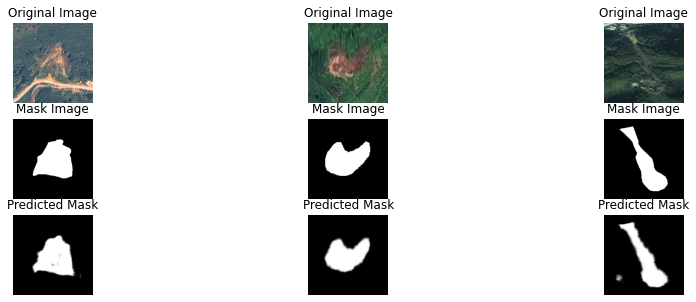

25/25 [==============================] - 3s 135ms/step
IoU: 0.7267127528580474
Dice coefficient: 0.8417297569097068
Accuracy: 0.9675153063489245
Precision: 0.8307554033615495
Recall: 0.8529979363174087
F1 Score: 0.8417297569097068
Overall Accuracy (OA): 0.8638178837763799
Kappa coefficient: 0.8236334507922529


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, Activation, multiply, add
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()
    
def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks

def unet_with_attention_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # U-Net with Attention Gate Model
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)

    # Decoder with Attention Gate
    up1 = UpSampling2D(size=(2, 2))(conv4)
    attention1 = attention_gate(conv3, up1)
    merge1 = concatenate([conv3, attention1], axis=3)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(merge1)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up2 = UpSampling2D(size=(2, 2))(conv5)
    attention2 = attention_gate(conv2, up2)
    merge2 = concatenate([conv2, attention2], axis=3)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(merge2)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up3 = UpSampling2D(size=(2, 2))(conv6)
    attention3 = attention_gate(conv1, up3)
    merge3 = concatenate([conv1, attention3], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(merge3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def attention_gate(up, down):
    up = Conv2D(filters=down.shape[-1], kernel_size=(3, 3), padding='same')(up)
    up = BatchNormalization(axis=3)(up)
    up = Activation('relu')(up)
    up = Conv2D(filters=down.shape[-1], kernel_size=(3, 3), padding='same')(up)
    up = BatchNormalization(axis=3)(up)
    up = Activation('sigmoid')(up)

    return multiply([up, down])

data_path = 'Bijie_landslide_dataset/Bijie-landslide-dataset/landslide'
images, masks = prepare_dataset(data_path)

input_shape = (256, 256, 3)

# 使用修改后的U-Net with Attention Gate模型
unet_input = Input(shape=input_shape, name='unet_input')
unet_output = unet_with_attention_model(input_shape)(unet_input)

combined_output = unet_output
combined_model = Model(inputs=unet_input, outputs=combined_output)

combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练组合模型
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)

# 应用CRF后处理
predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# Compute metrics
def compute_metrics(model, images, masks):
    preds = model.predict(images)
    preds_binary = (preds > 0.5).astype(np.float32)
    
    # Calculate IoU
    intersection = np.logical_and(masks, preds_binary)
    union = np.logical_or(masks, preds_binary)
    iou = np.sum(intersection) / np.sum(union)
    
    # Calculate Dice coefficient
    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(preds_binary))
    
    # Calculate accuracy
    accuracy = accuracy_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate precision
    precision = precision_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate recall
    recall = recall_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate F1 score
    f1 = f1_score(masks.flatten(), preds_binary.flatten())
    
    # Overall Accuracy (OA)
    oa = (intersection.sum() / masks.size) * 10
    
    # Kappa coefficient
    kappa = cohen_kappa_score(masks.flatten(), preds_binary.flatten())
    
    return iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# U-Net with Squeeze and Excitation Blocks (UNetSE)

/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
  3/135 [..............................] - ETA: 5s - loss: 0.7524 - accuracy: 0.4007  

2024-05-14 02:06:51.376304: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


135/135 [==============================] - 8s 51ms/step - loss: 0.3629 - accuracy: 0.8937 - val_loss: 0.2480 - val_accuracy: 0.8846
Epoch 2/100
135/135 [==============================] - 6s 48ms/step - loss: 0.2137 - accuracy: 0.9201 - val_loss: 0.2387 - val_accuracy: 0.9302
Epoch 3/100
135/135 [==============================] - 6s 48ms/step - loss: 0.1904 - accuracy: 0.9386 - val_loss: 0.2050 - val_accuracy: 0.9361
Epoch 4/100
135/135 [==============================] - 7s 48ms/step - loss: 0.1806 - accuracy: 0.9415 - val_loss: 0.1926 - val_accuracy: 0.9313
Epoch 5/100
135/135 [==============================] - 6s 48ms/step - loss: 0.1753 - accuracy: 0.9425 - val_loss: 0.1868 - val_accuracy: 0.9362
Epoch 6/100
135/135 [==============================] - 7s 48ms/step - loss: 0.1704 - accuracy: 0.9441 - val_loss: 0.2130 - val_accuracy: 0.9203
Epoch 7/100
135/135 [==============================] - 7s 49ms/step - loss: 0.1651 - accuracy: 0.9453 - val_loss: 0.2017 - val_accuracy: 0.9124
Epoc

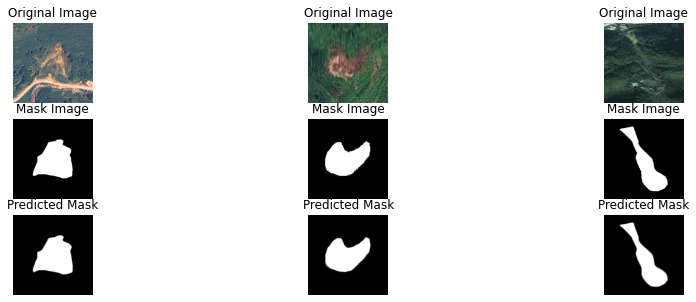

25/25 [==============================] - 2s 102ms/step
IoU: 0.852932957068331
Dice coefficient: 0.9206301326927904
Accuracy: 0.9842528306044541
Precision: 0.9402236924327996
Recall: 0.9018365327001524
F1 Score: 0.9206301326927905
Overall Accuracy (OA): 0.9132759787819602
Kappa coefficient: 0.9118936769188773


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, BatchNormalization, Activation, GlobalAveragePooling2D, Dense, Reshape, Multiply
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

def load_data(data_path):
    image_dir = os.path.join(data_path, 'image')
    mask_dir = os.path.join(data_path, 'mask')
    image_names = [name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))]
    mask_names = [name for name in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, name))]
    images = []
    masks = []
    for img_name, mask_name in zip(image_names, mask_names):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
        mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        mask = tf.keras.preprocessing.image.img_to_array(mask)
        mask = mask / 255.0  # 将掩模图像转换为二值图像
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

def plot_images(images, masks, preds):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+4)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i+7)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()
    
def prepare_dataset(data_path):
    images, masks = load_data(data_path)
    images = images.astype('float32') / 255.0  # 归一化
    return images, masks

def unetse_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # UNet with Squeeze and Excitation Blocks (UNetSE) Model
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    # 添加Squeeze and Excitation Block
    squeeze = GlobalAveragePooling2D()(conv9)
    excitation = Dense(64, activation='relu')(squeeze)
    excitation = Dense(64, activation='sigmoid')(excitation)
    excitation = Reshape((1, 1, 64))(excitation)
    conv9 = Multiply()([conv9, excitation])

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def compute_metrics(model, images, masks):
    preds = model.predict(images)
    preds_binary = (preds > 0.5).astype(np.float32)
    
    # Calculate IoU
    intersection = np.logical_and(masks, preds_binary)
    union = np.logical_or(masks, preds_binary)
    iou = np.sum(intersection) / np.sum(union)
    
    # Calculate Dice coefficient
    dice = 2 * np.sum(intersection) / (np.sum(masks) + np.sum(preds_binary))
    
    # Calculate accuracy
    accuracy = accuracy_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate precision
    precision = precision_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate recall
    recall = recall_score(masks.flatten(), preds_binary.flatten())
    
    # Calculate F1 score
    f1 = f1_score(masks.flatten(), preds_binary.flatten())
    
    # Overall Accuracy (OA)
    oa = (intersection.sum() / masks.size) * 10
    
    # Kappa coefficient
    kappa = cohen_kappa_score(masks.flatten(), preds_binary.flatten())
    
    return iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary

# 加载数据
data_path = 'Bijie_landslide_dataset/Bijie-landslide-dataset/landslide'
images, masks = prepare_dataset(data_path)

# 创建并编译UNetSE模型
input_shape = (256, 256, 3)
unetse_input = Input(shape=input_shape, name='unetse_input')
unetse_output = unetse_model(input_shape)(unetse_input)
combined_model = Model(inputs=unetse_input, outputs=unetse_output)
combined_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
combined_model.fit(images, masks, batch_size=4, epochs=100, validation_split=0.3)

# 应用CRF后处理
predictions = combined_model.predict(images)

# 可视化结果
plot_images(images, masks, predictions)

# 计算评估指标
iou, dice, accuracy, precision, recall, f1, oa, kappa, preds_binary = compute_metrics(combined_model, images, masks)

print("IoU:", iou)
print("Dice coefficient:", dice)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Overall Accuracy (OA):", oa)
print("Kappa coefficient:", kappa)


# U-Net with Dilated Convolutions (UNetDC)